In [2]:
!sudo apt-get install libmagickwand-dev
!pip install --no-cache-dir \
    opencv-python-headless==4.6.*\
    rawpy==0.17.* \
    pandas \
    Pillow==7.1.2 \
    scikit-image==0.16.2 \
    scipy==1.4.1 \
    tqdm \
    Wand

Reading package lists... Done
Building dependency tree       
Reading state information... Done
libmagickwand-dev is already the newest version (8:6.9.7.4+dfsg-16ubuntu6.14).
The following package was automatically installed and is no longer required:
  libnvidia-common-460
Use 'sudo apt autoremove' to remove it.
0 upgraded, 0 newly installed, 0 to remove and 20 not upgraded.
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [18]:
import tensorflow as tf
import utils
import os
from networks import custom_two_terms_loss_wrapper, custom_softmax_activation, custom_mse_wrapper
import numpy as np
import cv2
from skimage.util import view_as_windows
from utils import max_min_coefficient
from matplotlib import pyplot as plt
from PIL import Image
import io
import seaborn as sns

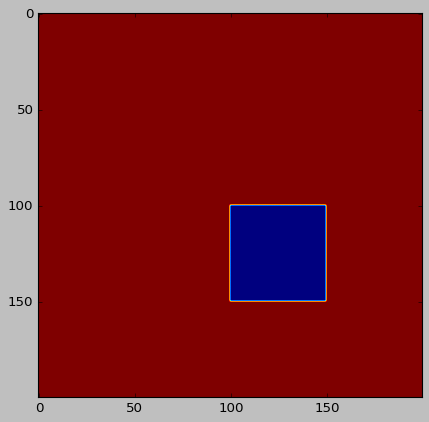

In [19]:
#Генерируем бинарную маску
mask=np.ones((200,200))
n=[100,150,100,150]
mask[n[0]:n[1],n[2]:n[3]]=0
plt.style.use('classic')
plt.imshow(mask)

In [133]:
#Сжатие изображения
def image_copression(image, qf):
  encode_param = [int(cv2.IMWRITE_JPEG_QUALITY), qf]
  result, encimg = cv2.imencode('.jpg', image, encode_param)
  jpeg_encoded_image = Image.open(io.BytesIO(encimg))
  return np.array(jpeg_encoded_image)

def image_insert(img1,img2,n):
  new_image=img1.copy()
  new_image[n[0]:n[1],n[2]:n[3]]=img2[n[0]:n[1],n[2]:n[3]]
  return new_image

In [26]:
#Генерация составных изображений
def create_a_few_image(name_dir,qf,n):
  files = os.listdir(path=name_dir)
  K=len(files)
  images=[]
  for i in range(0,K,2):
    img1=cv2.imread(name_dir+str(i+1)+'.tif')
    img2=cv2.imread(name_dir+str(i+2)+'.tif')

    image1=image_copression(img1,qf[0])
    image2=image_copression(img2,qf[1])

    double_image=image_insert(image2,image1,n)
    double_image=image_copression(double_image,qf[2])

    cv2.imwrite("sample_data/image_/img_"+str(i)+".jpg", double_image)
    images.append(double_image)
    
  return images

In [27]:
qf=[60,90,95]
name_dir='sample_data/image_/'
images=create_a_few_image(name_dir,qf,n)

In [28]:
def window_decision(img_data, model, max_coeffs, win_size=(64, 64), stride=1):
    """Divide input image into blocks then classify each block with a trained CNN model. Block scores are aggregated
       by means of average soft decision **on probability of being contrast enhanced**.

    Args:
       img_data: image matrix.
       model: trained CNN model (Keras)
       win_size: (height, width) of the image blocks. Default: (64, 64)
        stride: window stride
    Returns:
       Score
    """
    # Divide image into overlapping blocks
    image_view = view_as_windows(img_data, [win_size[0], win_size[1], 1], stride)
    h, w, c, _, _, _ = image_view.shape

    # Reshape the image view so that it is a stack of size N_blocks. Each element is a color patch BxBx3
    slices = image_view.reshape(h * w * c, win_size[0], win_size[1], 1)

    
    # Test the stack
    prediction = model.predict(slices, verbose=0)

    # Decode labels
    decoded_labels = np.zeros((prediction.shape[0], 15))
    for i, p in enumerate(prediction):
        decoded_labels[i, :] = utils.label2coefficient(p.flatten(), max_coefficients=max_coeffs)

    # Reshape decoded labels to the final map
    decoded_map = np.reshape(decoded_labels, (h, w, 15))
    decoded_map = cv2.resize(decoded_map, (img_data.shape[0], img_data.shape[1]))

    return decoded_map, decoded_labels

def preprocess_input(im, scale=255.):
    #im = cv2.imread(im_file)
    im = np.expand_dims(cv2.cvtColor(im, cv2.COLOR_BGR2YCrCb)[:, :, 0], -1)
    return im.astype(np.float32) / scale


def create_map(img,stride_):

    # Max value for coefficients
    max_coeffs, _ = max_min_coefficient(quality_range=(50, 100),
                                        n_coeffs=15,
                                        zig_zag_order=True)

    # Load model
    model_file = 'model_QF1_60-98_QF2_90-2-term-loss.h5'
    model = tf.keras.models.load_model(model_file,
                                       custom_objects=({'custom_softmax': custom_softmax_activation(max_coeffs),
                                                        'custom_two_terms_loss_wrapper': custom_two_terms_loss_wrapper(
                                                            max_coeffs, 0.8),
                                                        'custom_mse': custom_mse_wrapper(max_coeffs)})
                                       )

    # Read input image
    #input_image = 'sample_data/your_file2.jpg'
    img = preprocess_input(img)

    # Create map of size 57x57x15
    mapp, _ = window_decision(img, model, max_coeffs, (64, 64, 1), stride=stride_)
    return mapp

In [103]:
#Приводим значения полученной в пределы единицы и потом приводим к бинарному виду
def normalization(matr):
  max_=max(list(map(max, matr)))
  matr=matr/max_
  for i in range(matr.shape[1]):
    for j in range(matr.shape[1]):
      if(matr[i,j]>0.8):
        matr[i,j]=0
      else:
        matr[i,j]=1
  return matr

#Рассчитывает маски для всех изображений
def calculation_of_masks(images,stride_=1):
  mapps=[]
  for i in range(len(images)):
    mapp=create_map(images[i],stride_)
    mapps.append(mapp)
  return mapps


def section(mapps,n_koef):
  mapps_2=[]
  for i in range(len(mapps)):
    mapp=mapps[i][:,:,n_koef]
    mapp=normalization(mapp)
    mapps_2.append(mapp)
  return mapps_2

In [ ]:
mapps=calculation_of_masks(images)

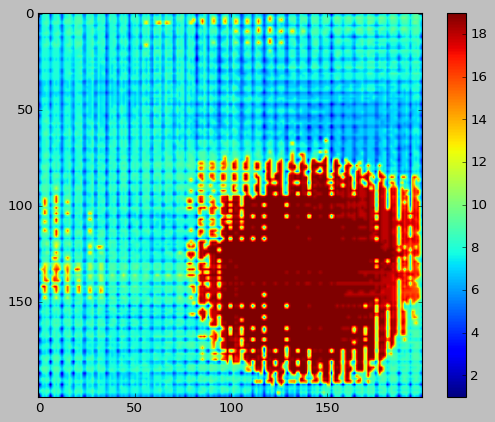

In [156]:
#Пример
plt.imshow(mapps[1][:,:,14])
plt.colorbar()

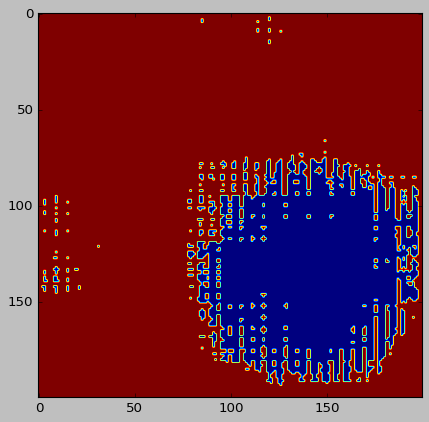

In [113]:
mapp_sections=section(mapps,14)
plt.imshow(mapp_sections[1])

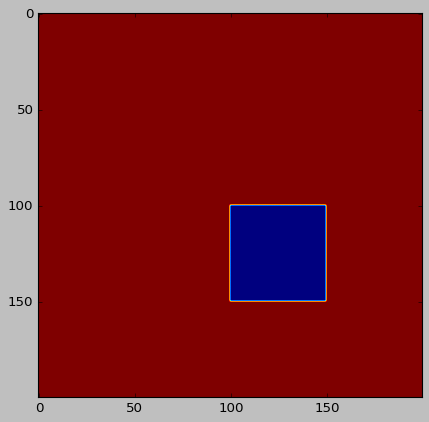

In [ ]:
plt.imshow(mask)

In [114]:
def two(matr,n):
  True_positiv_num=0
  False_negative_num=0
  False_positiv_num=0
  True_negative_num=0

  for i in range(matr.shape[0]):
    for j in range(matr.shape[1]):
      if(n[0]<i<n[1] and n[2]<j<n[3]):
        if(matr[i,j]==0):
          True_positiv_num+=1
        else:
          False_negative_num+=1
      else:
        if(matr[i,j]==1):
          True_negative_num+=1
        else:
          False_positiv_num+=1

  return True_positiv_num,False_negative_num,False_positiv_num,True_negative_num

#Оцениваем
def estimate(mapp_sections,n):
  f1=[]
  m=[]
  prec=[]
  acc=[]
  rec=[]
  for i in range(len(mapp_sections)):
    t_p,f_n,f_p,t_n=two(mapp_sections[i],n)
    mat=[[t_p,f_n],[f_p,t_n]]
    m.append(mat) 
    precision=t_p/(t_p+f_p)
    recall=t_p/(t_p+f_n)
    f=(2*precision*recall)/(precision+recall)
    accuracy=(t_p+t_n)/sum(sum(mat,[]))
    acc.append(accuracy)
    prec.append(precision)
    rec.append(recall)
    f1.append(f)
    
  return np.mean(acc),np.mean(f1),np.mean(rec),np.mean(prec),m

In [116]:
a,f,r,p,m=estimate(mapp_sections,n)

In [160]:
print('Accuracy',a)

Accuracy 0.85025


In [ ]:
'''print('F1',f)
print('Precision',p)
print('Recall',r)'''

In [32]:
#Пункт B5 - проверка зависимости результата от шага
def B5(images,n_koef,n,steps):
  f1=[]
  recall=[]
  precision=[]
  for s in steps:
    mapps=calculation_of_masks(images,s)
    np.save('sample_data/result/mapps_'+str(s),mapps)
    mapp_sections=section(mapps,n_koef)
    f,r,p,m=estimate(mapp_sections,n)
    f1.append(f)
    recall.append(r)
    precision.append(p)
  return f1,recall,precision

In [157]:
steps=[1,2,4,6,8,10,12,14,16,18,20]
f_b52,r_b52,p_b52=B5(images,14,n,steps)

In [118]:
#Пункт B5 - проверка зависимости результата от шага
def B5(images,n_koef,n,steps):
  f1=[]
  acc=[]
  recall=[]
  precision=[]
  for s in steps:
    mapps=np.load('sample_data/result/mapps_'+str(s)+'.npy')
    #np.save('sample_data/result/mapps_'+str(s),mapps)
    mapp_sections=section(mapps,n_koef)
    a,f,r,p,m=estimate(mapp_sections,n)
    f1.append(f)
    recall.append(r)
    precision.append(p)
    acc.append(a)
  return acc,f1,recall,precision


In [119]:
aa,ff_b52,rr_b52,pp_b52=B5(images,14,n,steps)

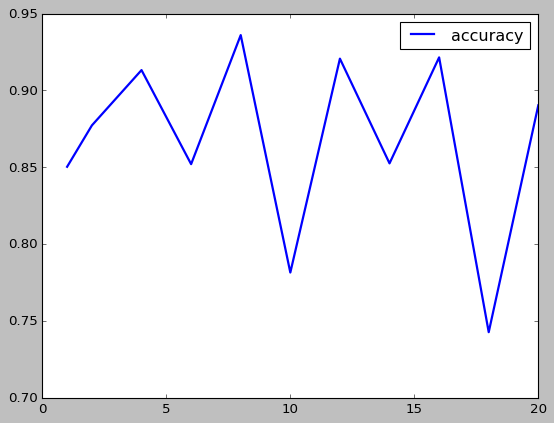

In [159]:
'''plt.plot(steps,f_b52, label = 'f1',linewidth = 2)
plt.plot(steps,r_b52, label = 'recall',linestyle = '-.',linewidth = 2)
plt.plot(steps,p_b52, label = 'precision',linestyle = '--',linewidth = 2)'''
plt.plot(steps,aa, label = 'accuracy',linewidth = 2)
plt.legend()

In [121]:
#Пункт B3
mask2=np.ones((200,200))
n2=[20,70,20,70]
mask2[n[0]:n[1],n[2]:n[3]]=0
mask2[n2[0]:n2[1],n2[2]:n2[3]]=0

In [145]:
def image_double_insert(img1,img2,img3,n,n2):
  new_image=img1.copy()
  new_image[n[0]:n[1],n[2]:n[3]]=img2[n[0]:n[1],n[2]:n[3]]
  new_image[n2[0]:n2[1],n2[2]:n2[3]]=img3[n2[0]:n2[1],n2[2]:n2[3]]
  return new_image
  
def create_image(name_dir,qf,n,n2):
  images=[]
  for i in range(0,6,3):
    img1=cv2.imread(name_dir+str(i+1)+'.tif')
    img2=cv2.imread(name_dir+str(i+2)+'.tif')
    img3=cv2.imread(name_dir+str(i+3)+'.tif')

    image1=image_copression(img1,qf[0])
    image2=image_copression(img2,qf[1])
    image3=image_copression(img3,qf[2])

    double_image=image_double_insert(image2,image1,image3,n,n2)
    double_image=image_copression(double_image,qf[3])
    cv2.imwrite("sample_data/image_/img_three_"+str(i)+".jpg", double_image)

    images.append(double_image)
    
  return images

In [146]:
qf2=[60,90,70,95]
iim=create_image(name_dir,qf2,n,n2)

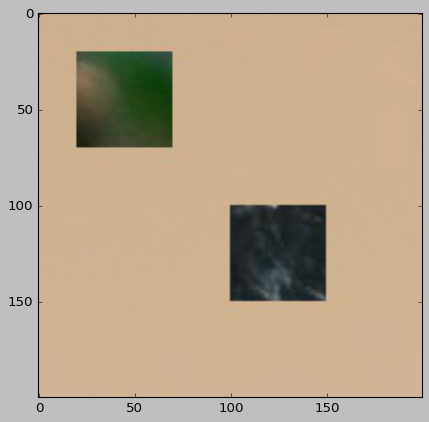

In [155]:
plt.imshow(iim[0])

In [153]:
mapps2=calculation_of_masks(iim,8)
mapp_sections2=section(mapps2,14)
plt.imshow(mapp_sections2[0])

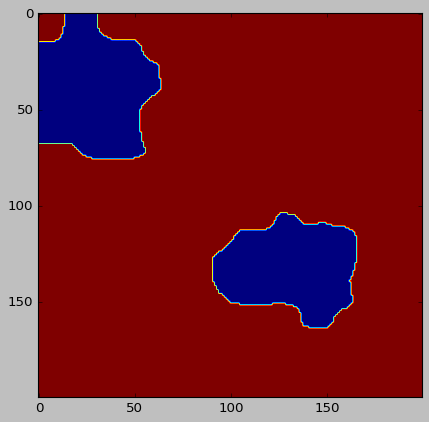

In [ ]:
mapp_sections2=section(mapps2,1)
plt.imshow(mapp_sections2[0])

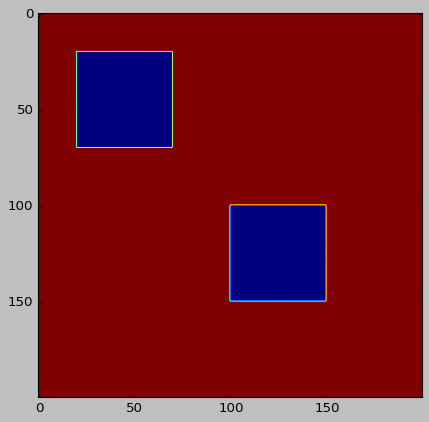

In [ ]:
plt.imshow(mask2)